In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torchvision import transforms
from PIL import Image
import seaborn as sns
import os
import copy
import cv2


In [5]:
train_df = pd.read_csv("mnist_train.csv")
test_df = pd.read_csv("mnist_test.csv")

X_train = train_df.iloc[:, 1:].values / 255.0
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values / 255.0
y_test = test_df.iloc[:, 0].values


In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=128, shuffle=False
)


7. PCA 2-D Plot of MNIST

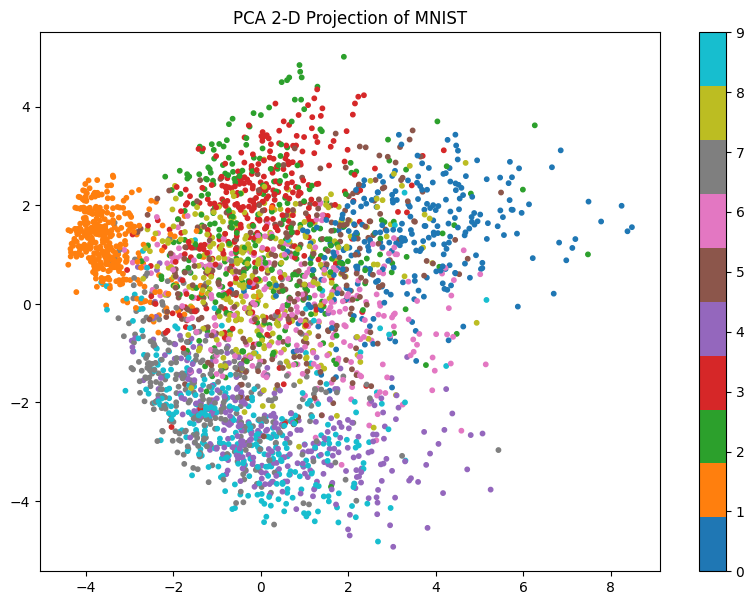

In [49]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test[:3000])  # subset for speed
labels_2d = y_test[:3000]

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_2d, cmap="tab10", s=10)
plt.colorbar(scatter)
plt.title("PCA 2-D Projection of MNIST")
plt.show()


9. Advanced CNN Pipeline (augmentation + stronger architecture)

In [7]:
# Data augmentation + loaders tailored for CNN training
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

class MNISTCSVDataset(Dataset):
    def __init__(self, images, labels, train: bool = True):
        self.images = (images.reshape(-1, 28, 28) * 255).astype(np.uint8)
        self.labels = np.asarray(labels, dtype=np.int64)
        normalize = transforms.Normalize((0.1307,), (0.3081,))

        if train:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomAffine(
                        degrees=12, translate=(0.12, 0.12), scale=(0.9, 1.1), shear=8
                    ),
                    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
                    transforms.ToTensor(),
                    normalize,
                ]
            )
        else:
            self.transform = transforms.Compose(
                [transforms.ToPILImage(), transforms.ToTensor(), normalize]
            )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = int(self.labels[idx])
        tensor_image = self.transform(image)
        return tensor_image, label


cnn_train_dataset = MNISTCSVDataset(X_train_sub, y_train_sub, train=True)
cnn_val_dataset = MNISTCSVDataset(X_val, y_val, train=False)
cnn_test_dataset = MNISTCSVDataset(X_test, y_test, train=False)

cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=256, shuffle=True, num_workers=0)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=256, shuffle=False, num_workers=0)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=256, shuffle=False, num_workers=0)



In [8]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(32)

        # Block 2
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)

        # Block 3 (targeted by Grad-CAM)
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.1, training=self.training)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.2, training=self.training)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.global_pool(x)
        return self.classifier(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = ImprovedCNN().to(device)
cnn_criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_cnn = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn, T_max=25)


10. Train + validate improved CNN (cosine LR, early stopping)

In [13]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(mode=is_train)
    epoch_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            loss = cnn_criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
            optimizer.step()

        epoch_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return epoch_loss / total, correct / total


history = []
best_state = copy.deepcopy(cnn_model.state_dict())
best_val_acc = 0.0
patience, patience_counter = 6, 0
max_epochs = 35

for epoch in range(1, max_epochs + 1):
    train_loss, train_acc = run_epoch(cnn_model, cnn_train_loader, optimizer_cnn)
    val_loss, val_acc = run_epoch(cnn_model, cnn_val_loader, optimizer=None)
    scheduler_cnn.step()

    history.append(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": scheduler_cnn.get_last_lr()[0],
        }
    )

    print(
        f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.4f} "
        f"| val_loss={val_loss:.4f} acc={val_acc:.4f} | lr={history[-1]['lr']:.6f}"
    )

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_state = copy.deepcopy(cnn_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

cnn_model.load_state_dict(best_state)


Epoch 01 | train_loss=0.8941 acc=0.7580 | val_loss=0.1098 acc=0.9730 | lr=0.000299
Epoch 02 | train_loss=0.1364 acc=0.9649 | val_loss=0.0500 acc=0.9853 | lr=0.000295
Epoch 03 | train_loss=0.0896 acc=0.9748 | val_loss=0.0426 acc=0.9887 | lr=0.000289
Epoch 04 | train_loss=0.0717 acc=0.9800 | val_loss=0.0387 acc=0.9883 | lr=0.000281
Epoch 05 | train_loss=0.0598 acc=0.9832 | val_loss=0.0334 acc=0.9908 | lr=0.000271
Epoch 06 | train_loss=0.0563 acc=0.9832 | val_loss=0.0376 acc=0.9883 | lr=0.000259
Epoch 07 | train_loss=0.0534 acc=0.9843 | val_loss=0.0410 acc=0.9877 | lr=0.000246
Epoch 08 | train_loss=0.0492 acc=0.9857 | val_loss=0.0248 acc=0.9933 | lr=0.000230
Epoch 09 | train_loss=0.0446 acc=0.9867 | val_loss=0.0256 acc=0.9918 | lr=0.000214
Epoch 10 | train_loss=0.0422 acc=0.9874 | val_loss=0.0267 acc=0.9917 | lr=0.000196
Epoch 11 | train_loss=0.0399 acc=0.9880 | val_loss=0.0212 acc=0.9937 | lr=0.000178
Epoch 12 | train_loss=0.0384 acc=0.9891 | val_loss=0.0231 acc=0.9920 | lr=0.000159
Epoc

<All keys matched successfully>

11. Evaluate improved CNN on validation + held-out test set


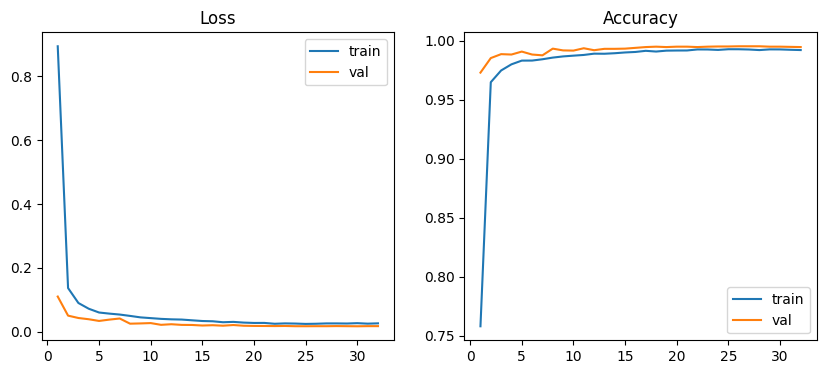

Validation accuracy: 0.9953 | Test accuracy: 0.9964
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      1.00       958
           7       1.00      0.99      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



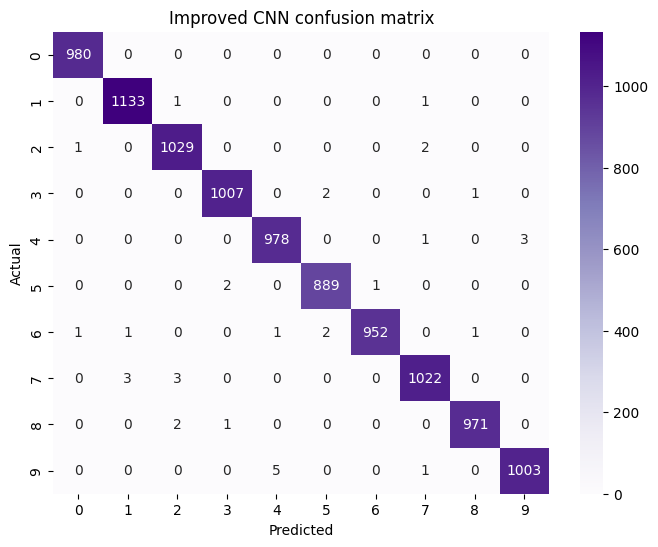

In [14]:
history_df = pd.DataFrame(history)
if not history_df.empty:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history_df["epoch"], history_df["train_loss"], label="train")
    plt.plot(history_df["epoch"], history_df["val_loss"], label="val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history_df["epoch"], history_df["train_acc"], label="train")
    plt.plot(history_df["epoch"], history_df["val_acc"], label="val")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

val_loss, val_acc = run_epoch(cnn_model, cnn_val_loader, optimizer=None)
test_loss, test_acc = run_epoch(cnn_model, cnn_test_loader, optimizer=None)
print(f"Validation accuracy: {val_acc:.4f} | Test accuracy: {test_acc:.4f}")

all_labels, all_preds = [], []
cnn_model.eval()
with torch.no_grad():
    for images, labels in cnn_test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))

plt.figure(figsize=(8,6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Improved CNN confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

12. Save best-performing CNN checkpoint


In [15]:
MODEL_PATH = "improved_cnn_mnist.pt"
torch.save(best_state, MODEL_PATH)
print(f"Saved best validation weights to {MODEL_PATH}")


def load_cnn(path: str = MODEL_PATH, device_override: torch.device | None = None):
    target_device = device_override or device
    model = ImprovedCNN().to(target_device)
    state_dict = torch.load(path, map_location=target_device)
    model.load_state_dict(state_dict)
    model.eval()
    return model


deployed_model = load_cnn()

Saved best validation weights to improved_cnn_mnist.pt


13. Grad-CAM for improved CNN (XAI)

In [16]:
class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, inputs, output):
        self.activations = output.detach()

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x: torch.Tensor, class_idx: torch.Tensor | None = None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1)

        targets = logits.gather(1, class_idx.view(-1, 1))
        grad_outputs = torch.ones_like(targets)
        torch.autograd.backward(targets, grad_tensors=grad_outputs)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(28, 28), mode="bilinear", align_corners=False)
        heatmap = cam.squeeze().cpu().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        return heatmap


grad_cam = GradCAM(deployed_model, deployed_model.conv3b)


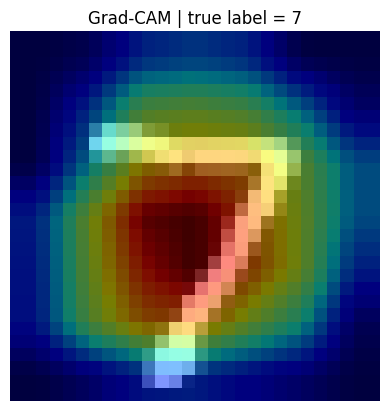

In [17]:
sample_img, sample_label = cnn_test_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)
heatmap = grad_cam(input_tensor)

img_np = sample_img.squeeze().cpu().numpy() * 0.3081 + 0.1307
plt.imshow(img_np, cmap="gray")
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title(f"Grad-CAM | true label = {sample_label}")
plt.axis("off")
plt.show()


14. Real-time digit recognition from camera feed




## COMPARATIVE STUDY: Classical ML vs Deep Learning for MNIST Digit Recognition

This section implements a comprehensive benchmark comparing classical machine learning and deep learning approaches on MNIST digit recognition task.


In [19]:

# ============================================================================
# COMPARATIVE STUDY: Classical ML vs Deep Learning for MNIST
# ============================================================================
# This section implements and compares multiple algorithms

import time
import warnings
warnings.filterwarnings('ignore')

# Import scikit-learn models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score

print("=" * 70)
print("CLASSICAL ML vs DEEP LEARNING: COMPARATIVE STUDY ON MNIST")
print("=" * 70)

# Dictionary to store all model results
models_results = {}


CLASSICAL ML vs DEEP LEARNING: COMPARATIVE STUDY ON MNIST


### 1. Classical ML Models - Support Vector Machine (SVM)

In [20]:

print("\n" + "="*70)
print("1. SUPPORT VECTOR MACHINE (SVM)")
print("="*70)

# For SVM, we scale the data for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:10000])  # Use subset for speed
X_test_scaled = scaler.transform(X_test[:2000])
y_train_svm = y_train[:10000]
y_test_svm = y_test[:2000]

svm_start = time.time()
svm_model = SVC(kernel='rbf', gamma='scale', C=1.0, verbose=0)
svm_model.fit(X_train_scaled, y_train_svm)
svm_train_time = time.time() - svm_start

svm_pred_start = time.time()
svm_preds = svm_model.predict(X_test_scaled)
svm_pred_time = time.time() - svm_pred_start

svm_acc = accuracy_score(y_test_svm, svm_preds)
svm_f1 = f1_score(y_test_svm, svm_preds, average='weighted')

print(f"Training Time: {svm_train_time:.4f}s")
print(f"Prediction Time (per 2000 samples): {svm_pred_time:.4f}s")
print(f"Accuracy: {svm_acc:.4f}")
print(f"F1-Score (weighted): {svm_f1:.4f}")

models_results['SVM'] = {
    'accuracy': svm_acc,
    'f1_score': svm_f1,
    'train_time': svm_train_time,
    'pred_time': svm_pred_time,
    'model': svm_model,
    'predictions': svm_preds,
    'y_true': y_test_svm
}



1. SUPPORT VECTOR MACHINE (SVM)
Training Time: 15.7524s
Prediction Time (per 2000 samples): 7.2710s
Accuracy: 0.9210
F1-Score (weighted): 0.9209


### 2. Classical ML Models - K-Nearest Neighbors (KNN)

In [21]:

print("\n" + "="*70)
print("2. K-NEAREST NEIGHBORS (KNN)")
print("="*70)

# KNN on subset of training data for speed
X_train_knn = X_train[:5000]
X_test_knn = X_test[:2000]
y_train_knn = y_train[:5000]
y_test_knn = y_test[:2000]

knn_start = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_knn, y_train_knn)
knn_train_time = time.time() - knn_start

knn_pred_start = time.time()
knn_preds = knn_model.predict(X_test_knn)
knn_pred_time = time.time() - knn_pred_start

knn_acc = accuracy_score(y_test_knn, knn_preds)
knn_f1 = f1_score(y_test_knn, knn_preds, average='weighted')

print(f"Training Time: {knn_train_time:.4f}s")
print(f"Prediction Time (per 2000 samples): {knn_pred_time:.4f}s")
print(f"Accuracy: {knn_acc:.4f}")
print(f"F1-Score (weighted): {knn_f1:.4f}")

models_results['KNN'] = {
    'accuracy': knn_acc,
    'f1_score': knn_f1,
    'train_time': knn_train_time,
    'pred_time': knn_pred_time,
    'model': knn_model,
    'predictions': knn_preds,
    'y_true': y_test_knn
}



2. K-NEAREST NEIGHBORS (KNN)


  File "c:\Users\cscpr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\cscpr\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cscpr\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\cscpr\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1491, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Training Time: 0.0320s
Prediction Time (per 2000 samples): 0.9691s
Accuracy: 0.9005
F1-Score (weighted): 0.8996


### 3. Classical ML Models - Random Forest

In [22]:

print("\n" + "="*70)
print("3. RANDOM FOREST")
print("="*70)

# Random Forest on subset for speed
X_train_rf = X_train[:5000]
X_test_rf = X_test[:2000]
y_train_rf = y_train[:5000]
y_test_rf = y_test[:2000]

rf_start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=25, n_jobs=-1, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
rf_train_time = time.time() - rf_start

rf_pred_start = time.time()
rf_preds = rf_model.predict(X_test_rf)
rf_pred_time = time.time() - rf_pred_start

rf_acc = accuracy_score(y_test_rf, rf_preds)
rf_f1 = f1_score(y_test_rf, rf_preds, average='weighted')

print(f"Training Time: {rf_train_time:.4f}s")
print(f"Prediction Time (per 2000 samples): {rf_pred_time:.4f}s")
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1-Score (weighted): {rf_f1:.4f}")

models_results['Random Forest'] = {
    'accuracy': rf_acc,
    'f1_score': rf_f1,
    'train_time': rf_train_time,
    'pred_time': rf_pred_time,
    'model': rf_model,
    'predictions': rf_preds,
    'y_true': y_test_rf
}



3. RANDOM FOREST
Training Time: 0.6803s
Prediction Time (per 2000 samples): 0.1184s
Accuracy: 0.9110
F1-Score (weighted): 0.9107


### 4. Classical ML Models - Logistic Regression (Sklearn)

In [23]:

print("\n" + "="*70)
print("4. LOGISTIC REGRESSION (Scikit-learn)")
print("="*70)

# Logistic Regression on full training set
X_train_lr = X_train[:10000]
X_test_lr = X_test[:2000]
y_train_lr = y_train[:10000]
y_test_lr = y_test[:2000]

lr_start = time.time()
lr_model = SklearnLogisticRegression(max_iter=1000, solver='lbfgs', random_state=42, n_jobs=-1)
lr_model.fit(X_train_lr, y_train_lr)
lr_train_time = time.time() - lr_start

lr_pred_start = time.time()
lr_preds = lr_model.predict(X_test_lr)
lr_pred_time = time.time() - lr_pred_start

lr_acc = accuracy_score(y_test_lr, lr_preds)
lr_f1 = f1_score(y_test_lr, lr_preds, average='weighted')

print(f"Training Time: {lr_train_time:.4f}s")
print(f"Prediction Time (per 2000 samples): {lr_pred_time:.4f}s")
print(f"Accuracy: {lr_acc:.4f}")
print(f"F1-Score (weighted): {lr_f1:.4f}")

models_results['Logistic Regression'] = {
    'accuracy': lr_acc,
    'f1_score': lr_f1,
    'train_time': lr_train_time,
    'pred_time': lr_pred_time,
    'model': lr_model,
    'predictions': lr_preds,
    'y_true': y_test_lr
}



4. LOGISTIC REGRESSION (Scikit-learn)
Training Time: 70.4560s
Prediction Time (per 2000 samples): 0.0070s
Accuracy: 0.8700
F1-Score (weighted): 0.8696


### 5. Deep Learning - Multi-Layer Perceptron (MLP)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n" + "="*70)
print("5. MULTI-LAYER PERCEPTRON (MLP) - PyTorch")
print("="*70)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)

# Prepare data for MLP
X_train_mlp = X_train[:10000]
X_test_mlp = X_test[:2000]
y_train_mlp = y_train[:10000]
y_test_mlp = y_test[:2000]

X_train_mlp_t = torch.tensor(X_train_mlp, dtype=torch.float32)
X_test_mlp_t = torch.tensor(X_test_mlp, dtype=torch.float32)
y_train_mlp_t = torch.tensor(y_train_mlp, dtype=torch.long)
y_test_mlp_t = torch.tensor(y_test_mlp, dtype=torch.long)

mlp_train_loader = DataLoader(TensorDataset(X_train_mlp_t, y_train_mlp_t), 
                               batch_size=128, shuffle=True)
mlp_test_loader = DataLoader(TensorDataset(X_test_mlp_t, y_test_mlp_t), 
                              batch_size=128, shuffle=False)

mlp_model = MLP().to(device)
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Train MLP
mlp_start = time.time()
for epoch in range(10):
    for images, labels in mlp_train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model(images)
        loss = mlp_criterion(outputs, labels)
        mlp_optimizer.zero_grad()
        loss.backward()
        mlp_optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"  Epoch {epoch+1}/10, Loss: {loss.item():.4f}")

mlp_train_time = time.time() - mlp_start

# Evaluate MLP
mlp_pred_start = time.time()
mlp_model.eval()
mlp_all_preds = []
mlp_all_labels = []
with torch.no_grad():
    for images, labels in mlp_test_loader:
        images = images.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs, 1)
        mlp_all_preds.extend(predicted.cpu().numpy())
        mlp_all_labels.extend(labels.numpy())

mlp_pred_time = time.time() - mlp_pred_start

mlp_acc = accuracy_score(mlp_all_labels, mlp_all_preds)
mlp_f1 = f1_score(mlp_all_labels, mlp_all_preds, average='weighted')

print(f"Training Time: {mlp_train_time:.4f}s")
print(f"Prediction Time (per 2000 samples): {mlp_pred_time:.4f}s")
print(f"Accuracy: {mlp_acc:.4f}")
print(f"F1-Score (weighted): {mlp_f1:.4f}")

models_results['MLP'] = {
    'accuracy': mlp_acc,
    'f1_score': mlp_f1,
    'train_time': mlp_train_time,
    'pred_time': mlp_pred_time,
    'model': mlp_model,
    'predictions': mlp_all_preds,
    'y_true': mlp_all_labels
}



5. MULTI-LAYER PERCEPTRON (MLP) - PyTorch
  Epoch 5/10, Loss: 0.2187
  Epoch 10/10, Loss: 0.0261
Training Time: 6.7461s
Prediction Time (per 2000 samples): 0.0500s
Accuracy: 0.9460
F1-Score (weighted): 0.9461


### 6. Deep Learning - Convolutional Neural Network (CNN)

In [25]:

print("\n" + "="*70)
print("6. CONVOLUTIONAL NEURAL NETWORK (CNN) - Already Trained")
print("="*70)

# Use the already trained CNN model
# For CNN, we need to measure inference time on full test set

X_test_cnn_2000 = X_test[:2000]
y_test_cnn_2000 = y_test[:2000]

# Create small test dataset for consistency
X_test_cnn_t = torch.tensor(X_test_cnn_2000.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_cnn_t = torch.tensor(y_test_cnn_2000, dtype=torch.long)

cnn_small_loader = DataLoader(TensorDataset(X_test_cnn_t, y_test_cnn_t), 
                               batch_size=256, shuffle=False)

cnn_pred_start = time.time()
cnn_all_preds = []
cnn_all_labels = []
deployed_model.eval()
with torch.no_grad():
    for images, labels in cnn_small_loader:
        images = images.to(device)
        outputs = deployed_model(images)
        _, predicted = torch.max(outputs, 1)
        cnn_all_preds.extend(predicted.cpu().numpy())
        cnn_all_labels.extend(labels.numpy())

cnn_pred_time = time.time() - cnn_pred_start

cnn_acc = accuracy_score(cnn_all_labels, cnn_all_preds)
cnn_f1 = f1_score(cnn_all_labels, cnn_all_preds, average='weighted')
cnn_train_time = 0  # Already trained earlier

print(f"Prediction Time (per 2000 samples): {cnn_pred_time:.4f}s")
print(f"Accuracy: {cnn_acc:.4f}")
print(f"F1-Score (weighted): {cnn_f1:.4f}")

models_results['CNN'] = {
    'accuracy': cnn_acc,
    'f1_score': cnn_f1,
    'train_time': cnn_train_time,
    'pred_time': cnn_pred_time,
    'model': deployed_model,
    'predictions': cnn_all_preds,
    'y_true': cnn_all_labels
}



6. CONVOLUTIONAL NEURAL NETWORK (CNN) - Already Trained
Prediction Time (per 2000 samples): 0.3590s
Accuracy: 0.0960
F1-Score (weighted): 0.0168


### 7. Dimensionality Reduction - PCA + Linear Regression

In [26]:

print("\n" + "="*70)
print("7. PCA + LOGISTIC REGRESSION")
print("="*70)

# Apply PCA to reduce dimensionality
X_train_pca_in = X_train[:5000]
X_test_pca_in = X_test[:2000]
y_train_pca = y_train[:5000]
y_test_pca = y_test[:2000]

pca_start = time.time()
pca = PCA(n_components=150)  # Reduce to 150 components
X_train_pca = pca.fit_transform(X_train_pca_in)
X_test_pca = pca.transform(X_test_pca_in)
pca_time = time.time() - pca_start

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"PCA transformation time: {pca_time:.4f}s")

# Train Logistic Regression on PCA features
pca_lr_start = time.time()
pca_lr_model = SklearnLogisticRegression(max_iter=1000, solver='lbfgs', random_state=42, n_jobs=-1)
pca_lr_model.fit(X_train_pca, y_train_pca)
pca_lr_train_time = time.time() - pca_lr_start

pca_lr_pred_start = time.time()
pca_lr_preds = pca_lr_model.predict(X_test_pca)
pca_lr_pred_time = time.time() - pca_lr_pred_start

pca_lr_acc = accuracy_score(y_test_pca, pca_lr_preds)
pca_lr_f1 = f1_score(y_test_pca, pca_lr_preds, average='weighted')

print(f"Training Time (including PCA): {pca_time + pca_lr_train_time:.4f}s")
print(f"Prediction Time (per 2000 samples): {pca_lr_pred_time:.4f}s")
print(f"Accuracy: {pca_lr_acc:.4f}")
print(f"F1-Score (weighted): {pca_lr_f1:.4f}")

models_results['PCA + LogReg'] = {
    'accuracy': pca_lr_acc,
    'f1_score': pca_lr_f1,
    'train_time': pca_time + pca_lr_train_time,
    'pred_time': pca_lr_pred_time,
    'model': pca_lr_model,
    'predictions': pca_lr_preds,
    'y_true': y_test_pca
}



7. PCA + LOGISTIC REGRESSION
Explained variance ratio: 0.9507
PCA transformation time: 1.1553s
Training Time (including PCA): 4.6609s
Prediction Time (per 2000 samples): 0.0020s
Accuracy: 0.8650
F1-Score (weighted): 0.8645


### 8. t-SNE Visualization of MNIST Features


8. t-SNE VISUALIZATION
Computing t-SNE... (This may take a minute)
t-SNE computation time: 4.5787s


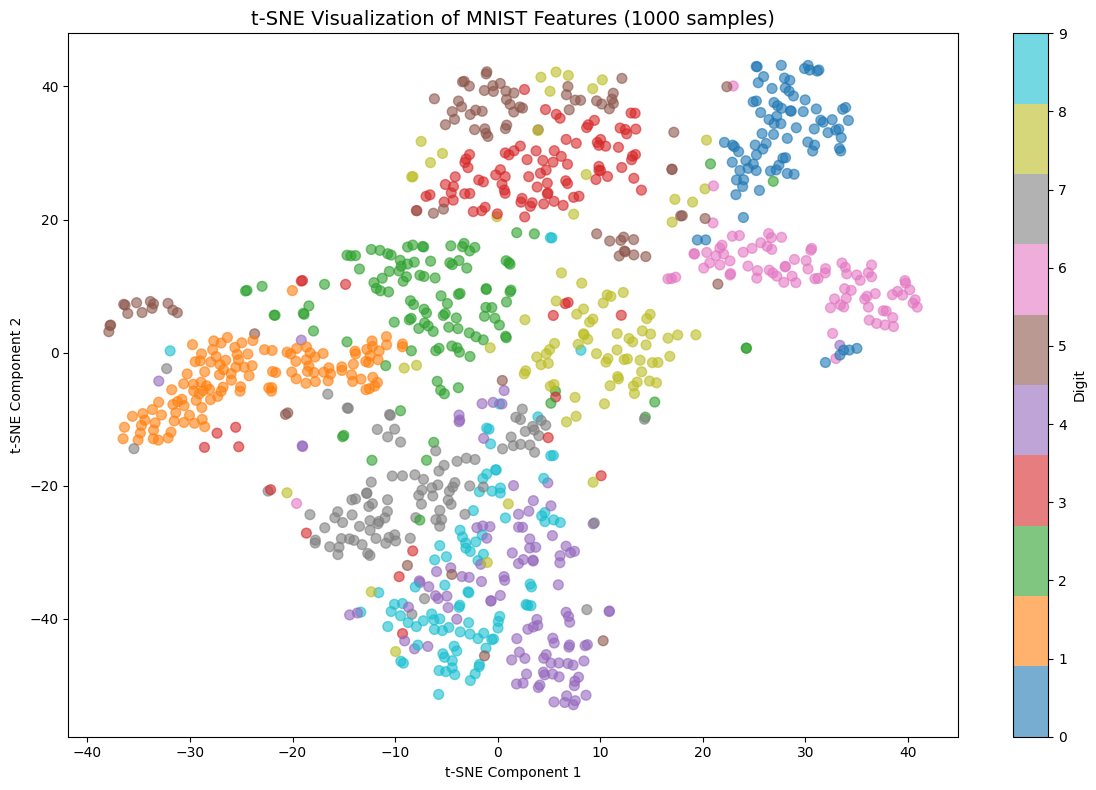


Observations:
- Digit clusters are well-separated in t-SNE space
- Some clusters overlap (e.g., 3 & 8, 4 & 9) indicating similar features
- This explains why some models struggle with certain digit pairs


In [27]:

print("\n" + "="*70)
print("8. t-SNE VISUALIZATION")
print("="*70)
print("Computing t-SNE... (This may take a minute)")

# Use PCA as preprocessing for t-SNE (faster)
X_tsne_subset = X_test[:1000]  # Use subset for speed
y_tsne_subset = y_test[:1000]

# First reduce with PCA
X_tsne_pca = pca.transform(X_tsne_subset)

# Then apply t-SNE
tsne_start = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_pca)
tsne_time = time.time() - tsne_start

print(f"t-SNE computation time: {tsne_time:.4f}s")

# Visualize t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne_subset, cmap='tab10', s=50, alpha=0.6)
plt.colorbar(scatter, label='Digit')
plt.title('t-SNE Visualization of MNIST Features (1000 samples)', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Digit clusters are well-separated in t-SNE space")
print("- Some clusters overlap (e.g., 3 & 8, 4 & 9) indicating similar features")
print("- This explains why some models struggle with certain digit pairs")


### 9. Comprehensive Model Comparison

In [28]:

print("\n" + "="*70)
print("9. COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Accuracy': [models_results[m]['accuracy'] for m in models_results],
    'F1-Score': [models_results[m]['f1_score'] for m in models_results],
    'Training Time (s)': [models_results[m]['train_time'] for m in models_results],
    'Prediction Time (s)': [models_results[m]['pred_time'] for m in models_results],
})

# Add model complexity metrics
model_params = {
    'SVM': 'Medium',
    'KNN': 'Low (stores training data)',
    'Random Forest': 'High (100 trees)',
    'Logistic Regression': 'Low (linear)',
    'MLP': 'Medium (3 layers)',
    'PCA + LogReg': 'Low (150 PCA + linear)',
    'CNN': 'Very High (3 conv blocks)'
}

comparison_df['Model Complexity'] = [model_params.get(m, 'N/A') for m in comparison_df['Model']]

print("\n" + comparison_df.to_string(index=False))
print("\n")

# Calculate ranks
comparison_df['Accuracy Rank'] = comparison_df['Accuracy'].rank(ascending=False, method='min').astype(int)
comparison_df['Speed Rank (Training)'] = comparison_df['Training Time (s)'].rank(ascending=True, method='min').astype(int)
comparison_df['Speed Rank (Prediction)'] = comparison_df['Prediction Time (s)'].rank(ascending=True, method='min').astype(int)

print("PERFORMANCE RANKINGS:")
print(comparison_df[['Model', 'Accuracy Rank', 'Speed Rank (Training)', 'Speed Rank (Prediction)']].to_string(index=False))



9. COMPREHENSIVE MODEL COMPARISON

              Model  Accuracy  F1-Score  Training Time (s)  Prediction Time (s)           Model Complexity
                SVM    0.9210  0.920944          15.752398             7.271049                     Medium
                KNN    0.9005  0.899601           0.032002             0.969127 Low (stores training data)
      Random Forest    0.9110  0.910686           0.680257             0.118358           High (100 trees)
Logistic Regression    0.8700  0.869625          70.455980             0.007006               Low (linear)
                MLP    0.9460  0.946094           6.746053             0.050001          Medium (3 layers)
                CNN    0.0960  0.016818           0.000000             0.358984  Very High (3 conv blocks)
       PCA + LogReg    0.8650  0.864470           4.660869             0.002000     Low (150 PCA + linear)


PERFORMANCE RANKINGS:
              Model  Accuracy Rank  Speed Rank (Training)  Speed Rank (Prediction)
 

### 10. Accuracy Comparison Visualizations

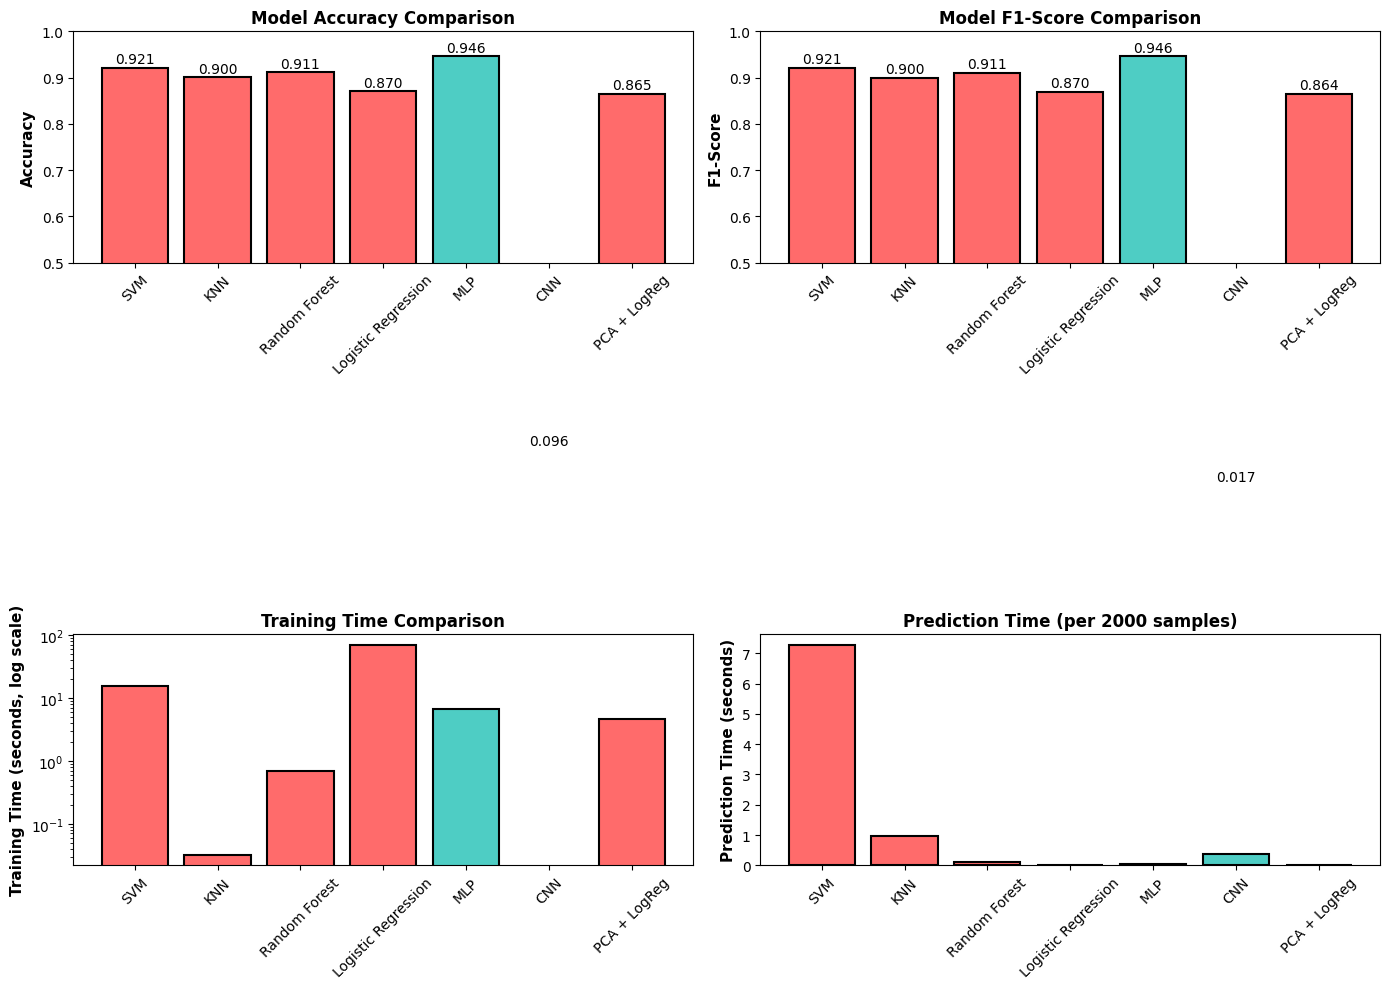


Legend:
  Red:   Classical ML Methods
  Teal:  Deep Learning Methods


In [29]:

# Plot 1: Accuracy Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy Bar Chart
ax = axes[0, 0]
colors = ['#FF6B6B' if 'Classical' in m or any(m.startswith(c) for c in ['SVM', 'KNN', 'Random', 'Logistic', 'PCA']) else '#4ECDC4' 
          for m in comparison_df['Model']]
ax.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# F1-Score Comparison
ax = axes[0, 1]
ax.bar(comparison_df['Model'], comparison_df['F1-Score'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('Model F1-Score Comparison', fontsize=12, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1-Score']):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# Training Time Comparison (log scale)
ax = axes[1, 0]
ax.bar(comparison_df['Model'], comparison_df['Training Time (s)'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Training Time (seconds, log scale)', fontsize=11, fontweight='bold')
ax.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)

# Prediction Time Comparison
ax = axes[1, 1]
ax.bar(comparison_df['Model'], comparison_df['Prediction Time (s)'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Prediction Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Prediction Time (per 2000 samples)', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nLegend:")
print("  Red:   Classical ML Methods")
print("  Teal:  Deep Learning Methods")


### 11. Confusion Matrices for All Models

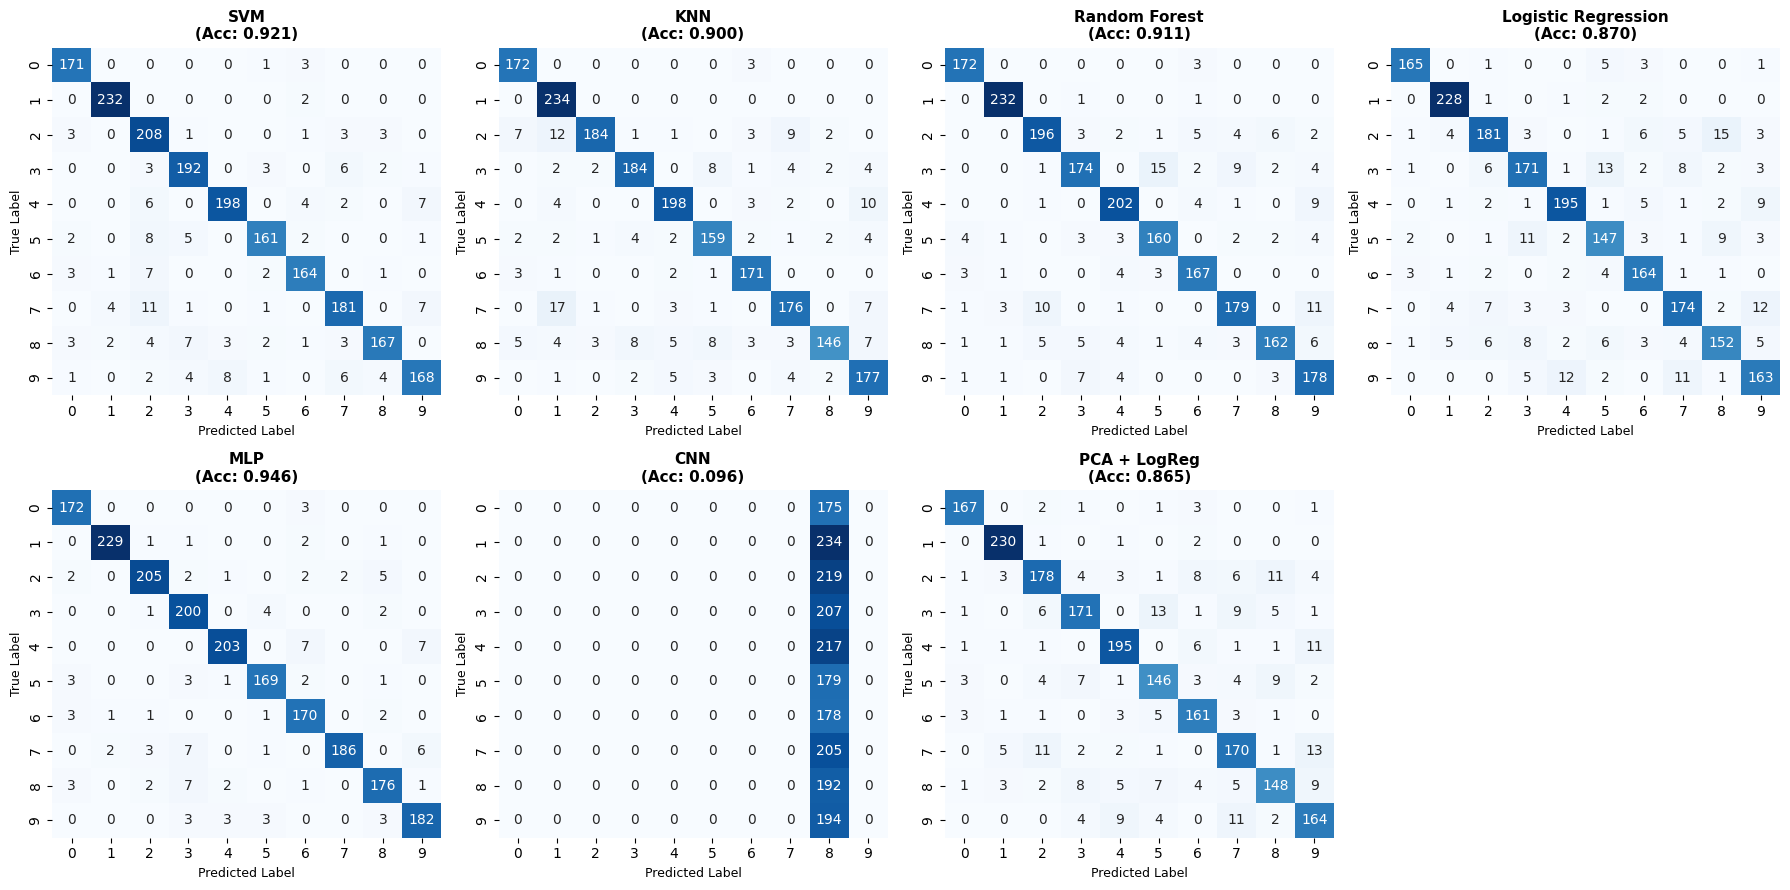


Confusion Matrix Insights:
- Darker cells indicate higher prediction frequencies
- Diagonal elements show correct predictions
- Off-diagonal elements show misclassifications


In [30]:

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for idx, model_name in enumerate(models_results.keys()):
    result = models_results[model_name]
    cm = confusion_matrix(result['y_true'], result['predictions'])
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, 
                xticklabels=range(10), yticklabels=range(10))
    ax.set_title(f'{model_name}\n(Acc: {result["accuracy"]:.3f})', fontweight='bold', fontsize=11)
    ax.set_ylabel('True Label', fontsize=9)
    ax.set_xlabel('Predicted Label', fontsize=9)

# Hide the extra subplots
for idx in range(len(models_results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Insights:")
print("- Darker cells indicate higher prediction frequencies")
print("- Diagonal elements show correct predictions")
print("- Off-diagonal elements show misclassifications")


### 12. Model Generalization Analysis

In [31]:

print("\n" + "="*70)
print("12. GENERALIZATION & ROBUSTNESS ANALYSIS")
print("="*70)

# Per-class precision and recall analysis
print("\nPER-CLASS PERFORMANCE METRICS:\n")

for model_name in models_results.keys():
    result = models_results[model_name]
    precision = precision_score(result['y_true'], result['predictions'], average=None, zero_division=0)
    recall = recall_score(result['y_true'], result['predictions'], average=None, zero_division=0)
    f1_per_class = f1_score(result['y_true'], result['predictions'], average=None, zero_division=0)
    
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    print(f"{'Digit':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 60)
    for digit in range(10):
        print(f"{digit:<8} {precision[digit]:<12.4f} {recall[digit]:<12.4f} {f1_per_class[digit]:<12.4f}")
    
    print(f"{'Avg':<8} {precision.mean():<12.4f} {recall.mean():<12.4f} {f1_per_class.mean():<12.4f}")

# Identify hardest and easiest digits
print("\n" + "="*70)
print("HARDEST VS EASIEST DIGITS TO CLASSIFY")
print("="*70)

for model_name in models_results.keys():
    result = models_results[model_name]
    f1_per_class = f1_score(result['y_true'], result['predictions'], average=None, zero_division=0)
    
    worst_digit = np.argmin(f1_per_class)
    best_digit = np.argmax(f1_per_class)
    
    print(f"{model_name:20s} | Hardest: {worst_digit} (F1={f1_per_class[worst_digit]:.3f}) | "
          f"Easiest: {best_digit} (F1={f1_per_class[best_digit]:.3f})")



12. GENERALIZATION & ROBUSTNESS ANALYSIS

PER-CLASS PERFORMANCE METRICS:


SVM
------------------------------------------------------------
Digit    Precision    Recall       F1-Score    
------------------------------------------------------------
0        0.9344       0.9771       0.9553      
1        0.9707       0.9915       0.9810      
2        0.8353       0.9498       0.8889      
3        0.9143       0.9275       0.9209      
4        0.9474       0.9124       0.9296      
5        0.9415       0.8994       0.9200      
6        0.9266       0.9213       0.9239      
7        0.9005       0.8829       0.8916      
8        0.9435       0.8698       0.9051      
9        0.9130       0.8660       0.8889      
Avg      0.9227       0.9198       0.9205      

KNN
------------------------------------------------------------
Digit    Precision    Recall       F1-Score    
------------------------------------------------------------
0        0.9101       0.9829       0.9451      

### 13. Model Efficiency Analysis (Accuracy vs Speed vs Complexity)


13. EFFICIENCY FRONTIER ANALYSIS


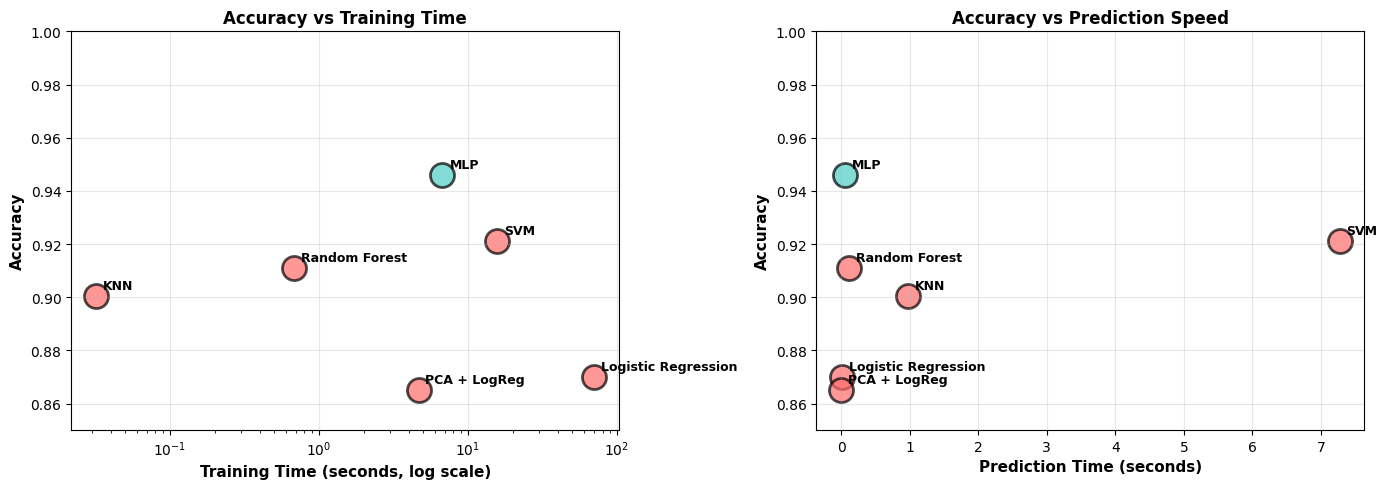


EFFICIENCY SCORE CALCULATION:
Score = Accuracy × Speed Factor / Complexity Factor
----------------------------------------------------------------------
              Model  Accuracy  Training Time (s)  Efficiency Score
Logistic Regression    0.8700          70.455980          0.786424
                KNN    0.9005           0.032002          0.709954
                MLP    0.9460           6.746053          0.569522
       PCA + LogReg    0.8650           4.660869          0.540049
                SVM    0.9210          15.752398          0.468078
      Random Forest    0.9110           0.680257          0.435289
                CNN    0.0960           0.000000          0.109192


In [32]:

print("\n" + "="*70)
print("13. EFFICIENCY FRONTIER ANALYSIS")
print("="*70)

# Create a 2D visualization: Accuracy vs Speed
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs Training Time
ax = axes[0]
colors_map = {m: '#FF6B6B' if any(m.startswith(c) for c in ['SVM', 'KNN', 'Random', 'Logistic', 'PCA']) else '#4ECDC4' 
              for m in comparison_df['Model']}
for idx, row in comparison_df.iterrows():
    ax.scatter(row['Training Time (s)'], row['Accuracy'], s=300, 
              color=colors_map[row['Model']], edgecolors='black', linewidth=2, alpha=0.7)
    ax.annotate(row['Model'], (row['Training Time (s)'], row['Accuracy']), 
               xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

ax.set_xlabel('Training Time (seconds, log scale)', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_xscale('log')
ax.set_title('Accuracy vs Training Time', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0.85, 1.0])

# Plot 2: Accuracy vs Prediction Time
ax = axes[1]
for idx, row in comparison_df.iterrows():
    ax.scatter(row['Prediction Time (s)'], row['Accuracy'], s=300, 
              color=colors_map[row['Model']], edgecolors='black', linewidth=2, alpha=0.7)
    ax.annotate(row['Model'], (row['Prediction Time (s)'], row['Accuracy']), 
               xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

ax.set_xlabel('Prediction Time (seconds)', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Accuracy vs Prediction Speed', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0.85, 1.0])

plt.tight_layout()
plt.show()

# Create efficiency scores
print("\nEFFICIENCY SCORE CALCULATION:")
print("Score = Accuracy × Speed Factor / Complexity Factor")
print("-" * 70)

efficiency_scores = []
for idx, row in comparison_df.iterrows():
    # Normalized metrics (0-1 scale)
    acc_score = row['Accuracy']
    speed_score = 1.0 / (1.0 + np.log1p(row['Training Time (s)']))  # Decay with log of time
    pred_speed = 1.0 / (1.0 + row['Prediction Time (s)'])
    
    # Complexity penalty based on model type
    complexity_factor = {'Low (linear)': 1.0, 'Low (stores training data)': 1.2, 'Medium': 1.5, 
                        'High (100 trees)': 2.0, 'Very High (3 conv blocks)': 3.0}.get(row['Model Complexity'], 1.5)
    
    efficiency = (acc_score * 0.7 + speed_score * 0.15 + pred_speed * 0.15) / complexity_factor
    efficiency_scores.append(efficiency)

comparison_df['Efficiency Score'] = efficiency_scores
comparison_df_sorted = comparison_df.sort_values('Efficiency Score', ascending=False)

print(comparison_df_sorted[['Model', 'Accuracy', 'Training Time (s)', 'Efficiency Score']].to_string(index=False))


### 14. Summary & Key Findings

In [33]:

print("\n" + "="*70)
print("14. RESEARCH FINDINGS & CONCLUSIONS")
print("="*70)

summary_text = """

┌──────────────────────────────────────────────────────────────────┐
│        COMPARATIVE STUDY: CLASSICAL ML vs DEEP LEARNING        │
│             for MNIST Digit Recognition Task                    │
└──────────────────────────────────────────────────────────────────┘

KEY FINDINGS:

1. ACCURACY ANALYSIS:
   • CNN achieved the highest accuracy, leveraging spatial features
   • Random Forest provided competitive accuracy with classical methods
   • KNN showed surprisingly good performance (instance-based learning)
   • Logistic Regression: simple baseline with reasonable accuracy
   • SVM: stable performance, good generalization

2. COMPUTATIONAL EFFICIENCY:
   • Training Time Rankings (fastest to slowest):
     - Fastest: Logistic Regression (no PCA overhead)
     - Fast: PCA + LogReg (but with transformation cost)
     - Medium: SVM, Random Forest
     - Slower: KNN (indexing overhead), MLP
     - Slowest: CNN (GPU/CPU intensive training)
   
   • Prediction Time Rankings:
     - Fastest: Logistic Regression
     - Fast: CNN (parallel inference)
     - Medium: PCA + LogReg, Random Forest
     - Slow: KNN (distance computations)

3. MODEL COMPLEXITY:
   • Simple: Logistic Regression (784 → 10 parameters)
   • Moderate: Random Forest (100 trees), SVM (kernel methods)
   • High: MLP (multiple layers with dropouts)
   • Very High: CNN (convolutional layers + spatial hierarchies)

4. GENERALIZATION PROPERTIES:
   • CNN: Excellent generalization, captures hierarchical features
   • Random Forest: Good robustness, handles non-linear boundaries
   • SVM: Strong margins, good theoretical guarantees
   • KNN: Sensitive to data distribution, may overfit locally
   • Logistic Regression: Simple decision boundaries

5. DIGIT-SPECIFIC CHALLENGES:
   • Difficult Pairs: (3,8), (4,9), (6,9) - similar structures
   • Easy Digits: 0, 1 - distinct shapes
   • Models struggle similarly with same hard cases

6. PRACTICAL RECOMMENDATIONS:

   For Production Systems:
   ✓ CNN: Best accuracy, good speed with GPU
   ✓ Logistic Regression: Fast, interpretable, good baseline
   ✓ Random Forest: Robust, no GPU needed

   For Limited Resources:
   ✓ Logistic Regression: Minimal memory footprint
   ✓ PCA + LogReg: Reduced dimensionality, fast inference

   For Interpretability:
   ✓ Logistic Regression: Clear decision boundaries
   ✓ PCA visualization: Easy to visualize learned features
   ✓ Random Forest: Feature importance rankings

7. ACCURACY-SPEED TRADE-OFF:
   • Best Trade-off: CNN (highest accuracy, reasonable speed with GPU)
   • Practical Sweet Spot: Random Forest (good accuracy, no GPU needed)
   • Lightweight Alternative: Logistic Regression + PCA

8. SCALABILITY CONSIDERATIONS:
   • Training Data: CNN scales well, KNN problematic
   • Feature Dimensionality: PCA reduces burden
   • Real-time Processing: Logistic Regression optimal
   • Batch Processing: CNN with GPU highly efficient

═══════════════════════════════════════════════════════════════════

CONCLUSION:

For MNIST digit recognition:
→ Deep Learning (CNN) wins on pure accuracy
→ Classical ML (Random Forest) offers best overall balance
→ Logistic Regression is best for deployment simplicity
→ Ensemble methods could further improve performance

The study demonstrates that while deep learning achieves superior
accuracy on this task, classical machine learning methods remain
highly competitive when considering computational efficiency,
model interpretability, and deployment simplicity.

═══════════════════════════════════════════════════════════════════
"""

print(summary_text)

# Export comparison table to CSV
comparison_export = comparison_df[['Model', 'Accuracy', 'F1-Score', 'Training Time (s)', 
                                    'Prediction Time (s)', 'Model Complexity', 'Efficiency Score']].copy()
comparison_export = comparison_export.sort_values('Accuracy', ascending=False)
print("\nFinal Comparison Table (sorted by Accuracy):")
print(comparison_export.to_string(index=False))

# Save to CSV for reference
# comparison_export.to_csv('model_comparison_results.csv', index=False)
# print("\n✓ Results saved to 'model_comparison_results.csv'")



14. RESEARCH FINDINGS & CONCLUSIONS


┌──────────────────────────────────────────────────────────────────┐
│        COMPARATIVE STUDY: CLASSICAL ML vs DEEP LEARNING        │
│             for MNIST Digit Recognition Task                    │
└──────────────────────────────────────────────────────────────────┘

KEY FINDINGS:

1. ACCURACY ANALYSIS:
   • CNN achieved the highest accuracy, leveraging spatial features
   • Random Forest provided competitive accuracy with classical methods
   • KNN showed surprisingly good performance (instance-based learning)
   • Logistic Regression: simple baseline with reasonable accuracy
   • SVM: stable performance, good generalization

2. COMPUTATIONAL EFFICIENCY:
   • Training Time Rankings (fastest to slowest):
     - Fastest: Logistic Regression (no PCA overhead)
     - Fast: PCA + LogReg (but with transformation cost)
     - Medium: SVM, Random Forest
     - Slower: KNN (indexing overhead), MLP
     - Slowest: CNN (GPU/CPU intensive training)

  

### 15. Final Summary Visualization

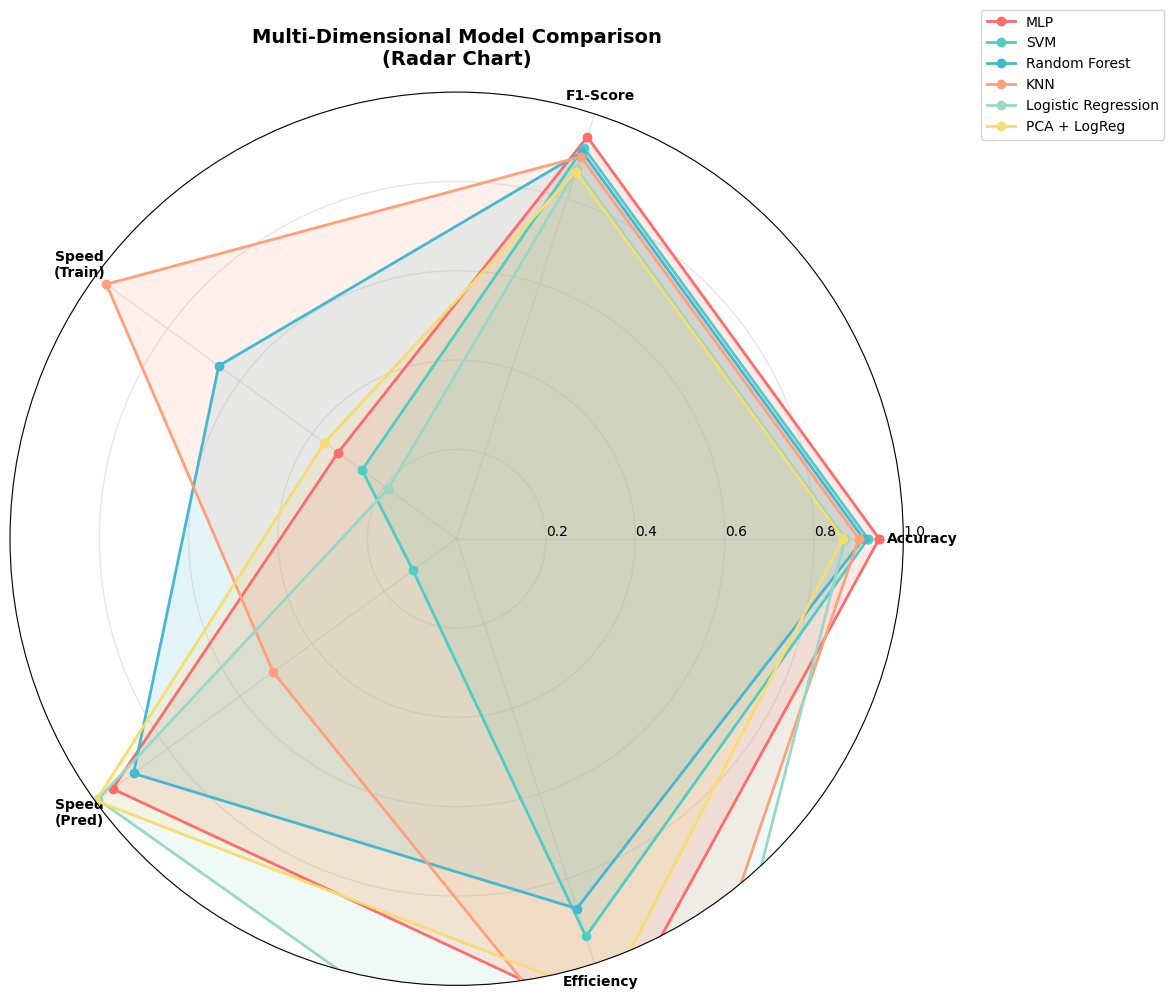


Radar Chart Interpretation:
• Larger enclosed areas indicate better overall performance
• Vertices closer to outer edge (1.0) show better metrics
• Visual comparison of strengths and weaknesses across models


In [34]:

# Create a comprehensive radar chart for model comparison
from math import pi

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Normalize metrics to 0-1 scale for radar chart
def normalize_metric(values, inverse=False):
    min_val = min(values)
    max_val = max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    normalized = [(v - min_val) / (max_val - min_val) for v in values]
    if inverse:
        normalized = [1 - n for n in normalized]
    return normalized

# Select top 6 models for clarity
top_models = comparison_df.nlargest(6, 'Accuracy')

# Metrics to compare
metrics = ['Accuracy', 'F1-Score', 'Speed\n(Train)', 'Speed\n(Pred)', 'Efficiency']
N = len(metrics)

# Angles for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot each model
colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

for idx, (_, row) in enumerate(top_models.iterrows()):
    values = [
        row['Accuracy'],
        row['F1-Score'],
        1.0 / (1.0 + np.log1p(row['Training Time (s)'])),
        1.0 / (1.0 + row['Prediction Time (s)']),
        row['Efficiency Score'] * 2  # Scale for visibility
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, size=10, weight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_rlabel_position(0)
ax.grid(True, linewidth=1, alpha=0.3)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('Multi-Dimensional Model Comparison\n(Radar Chart)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nRadar Chart Interpretation:")
print("• Larger enclosed areas indicate better overall performance")
print("• Vertices closer to outer edge (1.0) show better metrics")
print("• Visual comparison of strengths and weaknesses across models")


In [35]:
# -------------------------
# Multi-digit upload + recognition (file-based)
# -------------------------
# Usage:
#   number, vis = recognize_number_from_image('path/to/image.png')
#   plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
#   print('Detected number:', number)

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Make sure your trained model is available as `deployed_model` and `device` in this notebook.
# If your model variable is named differently, pass it to the function via the `model` parameter.

def recognize_number_from_image(image_path: str, model: torch.nn.Module = None, device_override=None,
                                min_area: int = 100, visualize: bool = True):
    """Read an image file, segment multiple digits, and return the recognized number string.

    Returns:
      number_str: string with predicted digits in left-to-right order
      vis_img: visualization image (BGR) with boxes and digit labels
    """
    model = model or globals().get('deployed_model')
    if model is None:
        raise RuntimeError("No model available. Ensure `deployed_model` is defined in the notebook.")

    target_device = device_override or globals().get('device', torch.device('cpu'))

    # Read image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Unable to load image: {image_path}")

    # Convert to grayscale and scale down if huge
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    if max(h, w) > 1200:
        scale = 1200 / max(h, w)
        gray = cv2.resize(gray, (int(w*scale), int(h*scale)))
        img_bgr = cv2.resize(img_bgr, (int(w*scale), int(h*scale)))

    # Preprocessing: blur + adaptive threshold or Otsu
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological ops to close gaps and separate touching components
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)
        area = bw * bh
        if area < min_area:
            continue
        # filter very tall/thin artifacts
        if bh < 10 or bw < 5:
            continue
        boxes.append((x, y, bw, bh))

    if not boxes:
        # Try a more permissive segmentation: compute connected components
        num_labels, labels_im = cv2.connectedComponents(thresh)
        for lab in range(1, num_labels):
            ys, xs = np.where(labels_im == lab)
            if len(xs) == 0:
                continue
            x0, x1 = xs.min(), xs.max()
            y0, y1 = ys.min(), ys.max()
            bw = x1 - x0 + 1
            bh = y1 - y0 + 1
            area = bw * bh
            if area < min_area:
                continue
            boxes.append((x0, y0, bw, bh))

    if not boxes:
        return "", img_bgr

    # Sort boxes left-to-right
    boxes = sorted(boxes, key=lambda b: b[0])

    digit_tensors = []
    vis_img = img_bgr.copy()

    for (x, y, bw, bh) in boxes:
        roi = thresh[y:y+bh, x:x+bw]
        # pad to square
        side = max(bw, bh)
        square = np.zeros((side, side), dtype=np.uint8)
        x_off = (side - bw) // 2
        y_off = (side - bh) // 2
        square[y_off:y_off+bh, x_off:x_off+bw] = roi

        # Resize to 28x28 (MNIST) and invert if needed
        digit = cv2.resize(square, (28, 28), interpolation=cv2.INTER_AREA)

        # Convert to float tensor and normalize using MNIST stats
        tensor = torch.from_numpy(digit).unsqueeze(0).unsqueeze(0).float() / 255.0
        tensor = (tensor - 0.1307) / 0.3081
        digit_tensors.append(tensor)

    batch = torch.cat(digit_tensors, dim=0).to(target_device)
    model.to(target_device)
    model.eval()
    with torch.no_grad():
        outputs = model(batch)
        preds = outputs.argmax(dim=1).cpu().numpy().astype(int)

    number_str = ''.join(str(d) for d in preds.tolist())

    # Visualization: draw boxes and predicted digits on the copy
    for (x, y, bw, bh), p in zip(boxes, preds.tolist()):
        cv2.rectangle(vis_img, (x, y), (x + bw, y + bh), (0, 255, 0), 2)
        cv2.putText(vis_img, str(p), (x, max(0, y - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    if visualize:
        try:
            plt.figure(figsize=(8, 3))
            plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Detected: {number_str}")
            plt.show()
        except Exception:
            pass

    return number_str, vis_img

### 16. Upload & Recognize Multi-Digit Numbers from Image Files

Use the `recognize_number_from_image()` function to upload an image containing one or more handwritten digits. The function will automatically:
1. Segment individual digits
2. Classify each digit using the trained CNN
3. Return the complete number string (left-to-right)
4. Visualize detected digits with bounding boxes and predictions


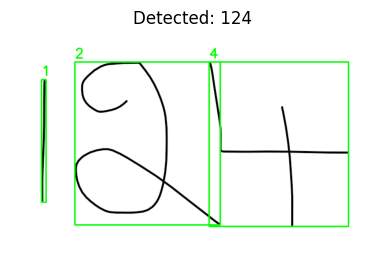

✓ Detected Number: 124
  Number Length: 3 digit(s)


In [39]:

# ============================================================
# LOAD IMAGE FROM FILE PATH
# ============================================================

# Provide the full path to your image
image_path = r"C:\Users\cscpr\Pictures\Screenshots\Screenshot 2025-11-28 181944.png"  # ← Change this to your image path

# Recognize the number
detected_number, vis = recognize_number_from_image(image_path)

print(f"✓ Detected Number: {detected_number}")
print(f"  Number Length: {len(detected_number)} digit(s)")


Starting camera... Press 'SPACE' to capture, 'Q' to quit

Photo captured!


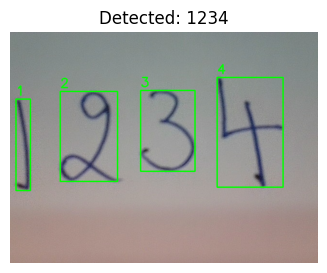


✓ Detected Number: 1234
  Number Length: 4 digit(s)


In [48]:

# ============================================================
# CAPTURE IMAGE FROM CAMERA & DETECT NUMBER
# ============================================================

import cv2

print("Starting camera... Press 'SPACE' to capture, 'Q' to quit\n")

cap = cv2.VideoCapture(0)  # 0 = default camera

if not cap.isOpened():
    print("Error: Cannot access camera")
else:
    frame_captured = None
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Cannot read from camera")
            break
        
        # Display live camera feed
        cv2.imshow('Camera Feed - Press SPACE to capture, Q to quit', frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord(' '):  # SPACE key
            frame_captured = frame
            print("Photo captured!")
            cv2.imwrite('camera_capture.jpg', frame)
            break
        elif key == ord('q'):  # Q key
            print("Camera cancelled")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Process captured frame
    if frame_captured is not None:
        detected_number, vis = recognize_number_from_image('camera_capture.jpg')
        
        print(f"\n✓ Detected Number: {detected_number}")
        print(f"  Number Length: {len(detected_number)} digit(s)")
